# Libraries and MNIST network

## Header

In [1]:
import sys
sys.path.append('/scratch/dengm/distent/Disentangle-features/archive')
from features import *
from metrics import *
import os
import torch as t
import torch.nn as nn
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

/data/scratch/dengm/anaconda3/envs/edm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MNIST

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 6)
        self.fc2 = nn.Linear(6, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
def Train_MNIST_net(cached_network = None, n_epochs = 6):
  '''
  Train a simple neural network on MNIST dataset
	Return: a trained MNIST network. 
  '''
  # MNIST train 
  import torch
  import torchvision
  import torch.nn as nn

  batch_size_train = 64
  batch_size_test = 1000
  learning_rate = 0.01
  momentum = 0.5
  log_interval = 10

  train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_train, shuffle=True)

  test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_test, shuffle=True)
  examples = enumerate(test_loader)
  batch_idx, (example_data, example_targets) = next(examples)
  
  if cached_network is not None:
    network = cached_network
  else:
    network = Net()
  optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                        momentum=momentum)
  def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = network(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
  def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        output = network(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    # test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  test()
  for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
  return network


def Generate_MNIST(net):
  import torch
  import torchvision
  import torch.nn as nn
  import torch.nn.functional as F
  import torch.optim as optim
    
  '''
  net: a trained network
  return: a tuple of (activations, data)
  '''
  # set seed for data loader
  torch.manual_seed(1)
  
  train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ])),
    batch_size=64, 
    shuffle=True)
  
  def activation(net, x):
    net.eval()
    with torch.inference_mode():
      x = F.relu(F.max_pool2d(net.conv1(x), 2))
      x = F.relu(F.max_pool2d(net.conv2_drop(net.conv2(x)), 2))
      x = x.view(-1, 320)
      x = net.fc1(x)
      return x
  datas = []
  actis = []
  targets = []
  for data, target in train_loader:
    actis.append(activation(net, data))
    datas.append(data)
    targets.append(target)
  return torch.cat(actis, 0), torch.cat(datas, 0), torch.cat(targets, 0)

In [3]:
load = True
if load:
    net = Net()
    net.load_state_dict(torch.load('mnist_net.pth'))
else:
    net = Train_MNIST_net() 
    torch.save(net.state_dict(), 'mnist_net.pth')   

# Disentangle

In [4]:
acti, data, target = Generate_MNIST(net)
print(acti.shape, data.shape, target.shape)

/data/scratch/dengm/anaconda3/envs/edm/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data/scratch/dengm/anaconda3/envs/edm/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


torch.Size([60000, 6]) torch.Size([60000, 1, 28, 28]) torch.Size([60000])


In [5]:

from features import *
load = True
if load:
    feat, emb, info = load_wrapper('gd', 'mnist')
else:
    samples = 10000
    feat, emb, info = wrapper('gd', 'mnist', t.Tensor(acti[:samples]).to(device), init_lamb = 3, lamb_left = 0.4, lamb_right = 0.6, guess_factor=8, lr = 1e-2, steps = 10000)


Loaded config:  [] {'init_lamb': '3', 'lamb_left': '0.4', 'lamb_right': '0.6', 'guess_factor': '8', 'lr': '0.01', 'steps': '10000'}


## Sparsity indicators

In [6]:
print(sparse_metric_mean_scaled(1)(feat))
print(sparse_metric_mean_scaled(0.7)(feat))
print(sparse_metric_mean(1)(feat))
print(sparse_metric_mean(0.7)(feat))

tensor(2.4615)
tensor(2.7957)
tensor(1.7307)
tensor(2.0563)


# R2 score of features with ground truth

In [7]:
def r2(x, y):
    # first, do linear regression
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    pred = slope * x + intercept
    # then, compute r2
    from sklearn.metrics import r2_score
    return r2_score(y, pred)

### Compute ground truth features

In [8]:
def average_max_r2(target, feat, samples = 10000, corr_type = 'r2'):
    r2_list = []
    for j in range(10):
        maxr2 = -1e9
        true_eq = target[:samples] == j
        true_eq = true_eq.float()
        for k in range(feat.shape[1]):
            if corr_type == 'pearson':
                maxr2 = max(maxr2, pearsonr(true_eq, feat[:samples, k])[0])
            elif corr_type == 'r2':
                maxr2 = max(maxr2, r2(true_eq, feat[:samples, k]))
            else:
                raise NotImplementedError
        r2_list.append(maxr2)
    return np.mean(r2_list)

In [9]:
filler_size = feat.shape[1] - acti.shape[1]
torch.manual_seed(1)
def random_transformation(acti, size):
    dirs = t.randn(acti.shape[1], size)
    dirs = dirs / t.norm(dirs, dim = 0)
    return dirs, (t.tensor(acti).to(t.float32) @ dirs)
samples = feat.shape[0]
filled_dir, filled_acti = random_transformation(acti[:samples], filler_size)
filled_dir, filled_acti = t.concatenate([t.eye(acti.shape[1]), filled_dir], dim = 1), t.concatenate([acti[:samples], filled_acti], dim = 1)
random_dir, random_acti = random_transformation(acti[:samples], feat.shape[1])

from sklearn.decomposition import PCA
pca = PCA(n_components=acti.shape[1])
pca.fit(acti[:samples])
pca_dir = pca.components_
pca_acti = pca.transform(acti[:samples])
filled_pca_dir, filled_pca_acti =  random_transformation(acti[:samples], filler_size)
filled_pca_dir, filled_pca_acti = t.concatenate([t.tensor(pca_dir), filled_pca_dir], dim = 1), t.concatenate([t.tensor(pca_acti), filled_pca_acti], dim = 1)

comparison_list = [feat, filled_acti, random_acti, filled_pca_acti, acti[:samples], pca_acti]
dir_list = [emb, filled_dir, random_dir, filled_pca_dir, t.eye(acti.shape[1]), pca_dir]
names = ['feat', 'filled_acti', 'random_acti', 'filled_pca_acti', 'acti', 'pca_acti']
# change all to numpy
for i in range(len(comparison_list)):
    if isinstance(comparison_list[i], t.Tensor):
        comparison_list[i] = comparison_list[i].cpu().detach().numpy()

/tmp/ipykernel_3838344/365577810.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return dirs, (t.tensor(acti).to(t.float32) @ dirs)
/tmp/ipykernel_3838344/365577810.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return dirs, (t.tensor(acti).to(t.float32) @ dirs)


In [10]:
for (ft, name) in zip(comparison_list, names):
    print(name, "pearsonr:", average_max_r2(target, ft, samples, 'pearson'), "r2", average_max_r2(target, ft, samples, 'r2'))
    # print(name, average_max_r2(target, feat, samples, 'r2'))

feat pearsonr: 0.6511332621212328 r2 0.42506096916882596
filled_acti pearsonr: 0.5687847122203495 r2 0.3434323752206224
random_acti pearsonr: 0.5594489492405961 r2 0.3803688063210523
filled_pca_acti pearsonr: 0.546706037854327 r2 0.34827822082617504
acti pearsonr: 0.44806612320955636 r2 0.2720668905016305
pca_acti pearsonr: 0.36850406777832745 r2 0.27529102887879253


# Ablation test

In [11]:
import random

def ablation_zero(feat, nums):
  feat_top_id = feat.abs().argsort(dim=1)[:, -nums:]
  feat_top = t.zeros_like(feat).scatter_(1, feat_top_id, 1)
  result = t.zeros_like(feat)
  for i in range(feat.shape[0]):
    result[i] = feat[i] * feat_top[i]
  return result

def ablation_scrubb(feat, nums):
  feat_top_id = feat.abs().argsort(dim=1)[:, -nums:]
  feat_top = t.zeros_like(feat).scatter_(1, feat_top_id, 1)
  result = t.zeros_like(feat)
  for i in range(feat.shape[0]):    
    another_id = random.randint(0, feat.shape[0] - 1)

    non_overlap = (1 - feat_top[i]) * (1 - feat_top[another_id])
    result[i] = feat[i] * (1 - non_overlap) + feat[another_id] * non_overlap
  return result

In [12]:
import torch
def result(net, acti):
  net.eval()
  import torch.nn.functional as F
  with torch.inference_mode():
    output = net.fc2(F.relu(acti))
    output = F.log_softmax(output)
    loss = F.nll_loss(output, target[:acti.shape[0]], size_average=True).item()
    pred = output.data.max(1, keepdim=True)[1]
    correct = pred.eq(target[:acti.shape[0]].data.view_as(pred)).sum() 
    # print(correct)
    return correct.item() / len(pred)
torch.manual_seed(1)
def construct_random_sample(sample, size):
  dir = t.randn(size, acti.shape[1])
  dir = dir / t.norm(dir, dim = 1, keepdim = True)
  picked_dir = t.zeros((sample, acti.shape[1], acti.shape[1]))
  picked_coeff = t.zeros((sample, acti.shape[1]))
  result_coeff = t.zeros((sample, size))
  for i in range(sample):
    random_ids = t.randperm(size)[:acti.shape[1]]
    picked_dir[i] = dir[random_ids, :]
    picked_coeff[i] = acti[i] @ picked_dir[i].inverse()
    result_coeff[i, random_ids] = picked_coeff[i]
  return result_coeff, dir
random_coeff, random_dir = construct_random_sample(feat.shape[0], feat.shape[1])


comparison_list = [feat, acti[:samples], pca_acti, random_coeff]
dir_list = [emb, t.eye(acti.shape[1]), pca_dir, random_dir]
names = ['feat', 'acti', 'pca_acti', 'random']

for (elt, dir, name) in zip(comparison_list, dir_list, names):
    if 'pca' in name:
      mean_acti = acti[:samples].mean(dim = 0)
    else:
      mean_acti = t.zeros(acti.shape[1])
    elt = t.tensor(elt).float()
    dir = t.tensor(dir).float()
    print(name)
    print(f'{name}, initial accuracy: {result(net, elt @ dir + mean_acti)}')
    for nums in range(1, 3):
      abla_zero_acc = result(net, ablation_zero(elt, nums) @ dir + mean_acti)
      abla_scrubb_acc = result(net, ablation_scrubb(elt, nums) @ dir + mean_acti)
      print(f'{name}, scrubb out everything except top {nums}, {abla_zero_acc}')
      print(f'{name}, replace everything except top {nums}, {abla_scrubb_acc}')

/tmp/ipykernel_3838344/751779089.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elt = t.tensor(elt).float()
/tmp/ipykernel_3838344/751779089.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dir = t.tensor(dir).float()
/tmp/ipykernel_3838344/751779089.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(output)
/data/scratch/dengm/anaconda3/envs/edm/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


feat
feat, initial accuracy: 0.9383
feat, scrubb out everything except top 1, 0.9172
feat, replace everything except top 1, 0.6349
feat, scrubb out everything except top 2, 0.9354
feat, replace everything except top 2, 0.8895
acti
acti, initial accuracy: 0.9379
acti, scrubb out everything except top 1, 0.4175
acti, replace everything except top 1, 0.3204
acti, scrubb out everything except top 2, 0.5634
acti, replace everything except top 2, 0.5116
pca_acti
pca_acti, initial accuracy: 0.9379
pca_acti, scrubb out everything except top 1, 0.5454
pca_acti, replace everything except top 1, 0.5234
pca_acti, scrubb out everything except top 2, 0.8292
pca_acti, replace everything except top 2, 0.7946
random
random, initial accuracy: 0.9379
random, scrubb out everything except top 1, 0.2346
random, replace everything except top 1, 0.1552
random, scrubb out everything except top 2, 0.3391
random, replace everything except top 2, 0.2105


# TSNE visualization

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.256305
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.211182
[t-SNE] KL divergence after 300 iterations: 2.285134
[t-SNE] Computing 121 nea

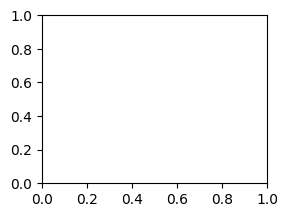

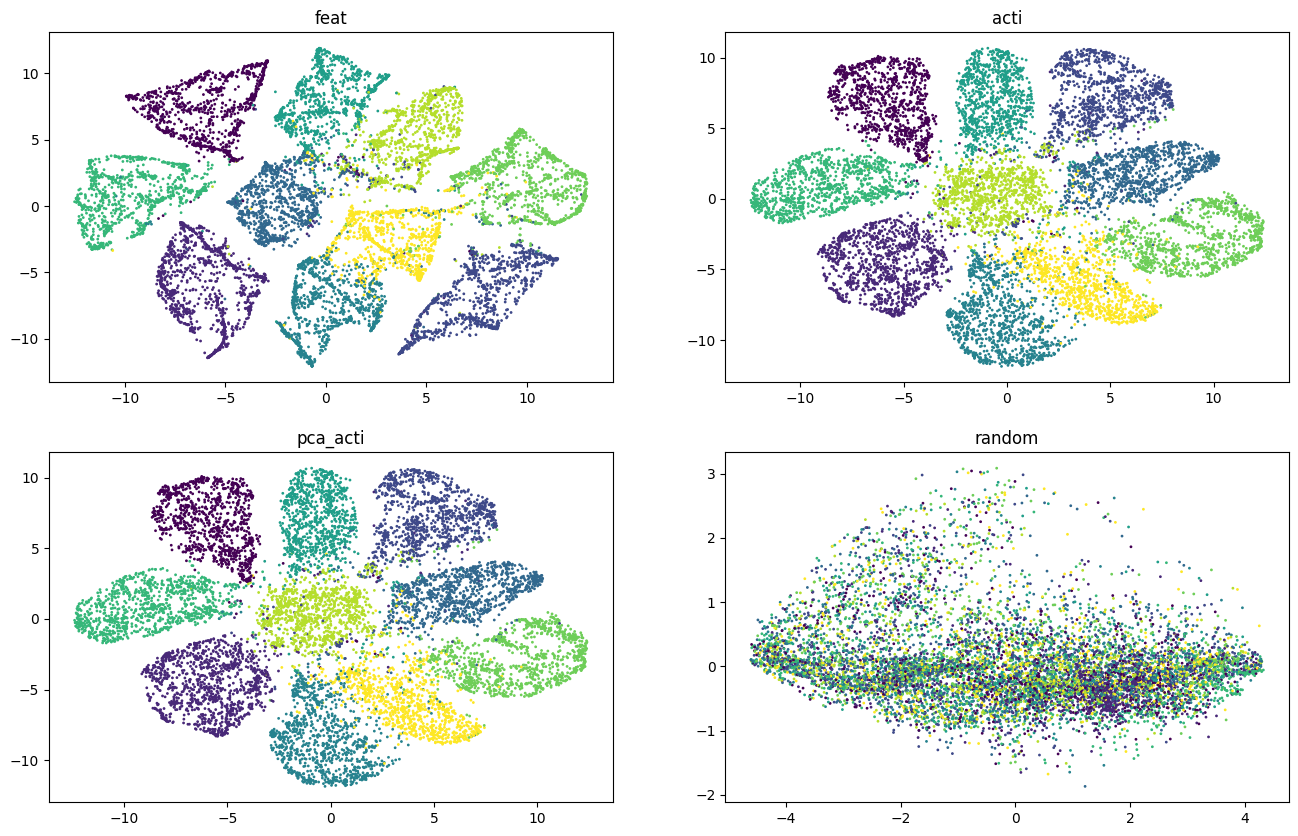

In [20]:
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def tsne_show(feat):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(feat)
    X = tsne_results[:, 0]
    Y = tsne_results[:, 1]
    plt.scatter(X, Y, c = target[:feat.shape[0]], s = 1)
plt.subplot(2, 2, 1)
plt.figure(figsize=(16, 10))
for (id, elt, name) in zip(range(1, 5), comparison_list, names):
    plt.subplot(2, 2, id)
    tsne_show(elt)
    plt.title(name)
plt.savefig('mnist_tsne.png')

/tmp/ipykernel_3831357/3340277600.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elt = t.tensor(elt).float()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.322690
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.785694
[t-SNE] KL divergence after 300 iterations: 1.663698


/tmp/ipykernel_3831357/3340277600.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elt = t.tensor(elt).float()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.690s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.066512
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.932961
[t-SNE] KL divergence after 300 iterations: 1.663989
[t-SNE] Computing 121 nea

/tmp/ipykernel_3831357/3340277600.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elt = t.tensor(elt).float()


[t-SNE] Computed neighbors for 10000 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.141357
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.067642
[t-SNE] KL divergence after 300 iterations: 1.797396


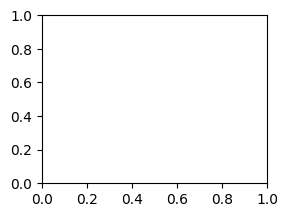

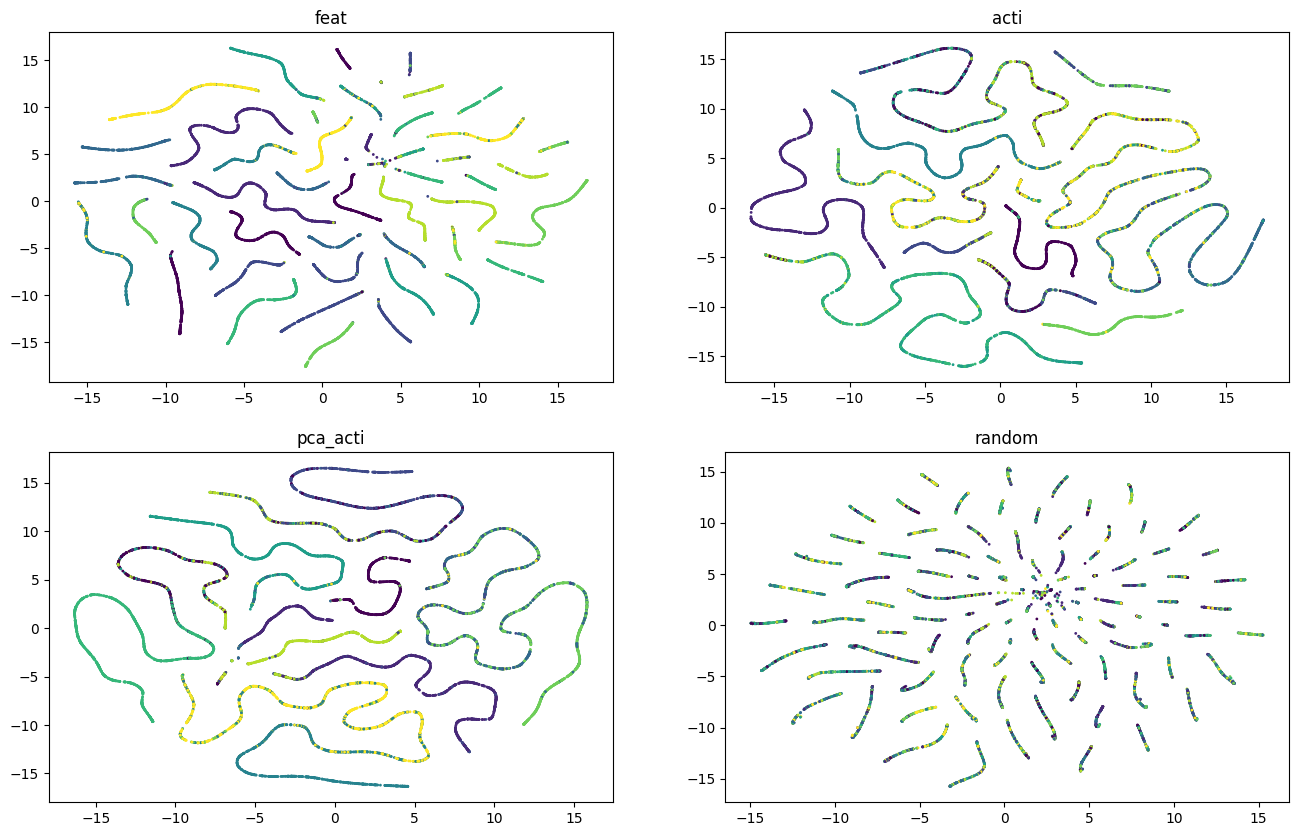

In [21]:
plt.subplot(2, 2, 1)
plt.figure(figsize=(16, 10))
for (id, elt, name) in zip(range(1, 5), comparison_list, names):
    plt.subplot(2, 2, id)
    elt = t.tensor(elt).float()
    elt = ablation_zero(elt, 1)
    tsne_show(elt)
    plt.title(name)
plt.savefig('mnist_tsne_ablation_zero.png')

/tmp/ipykernel_3831357/3064337136.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elt = t.tensor(elt).float()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.869911
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.715286
[t-SNE] KL divergence after 300 iterations: 2.287023


/tmp/ipykernel_3831357/3064337136.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elt = t.tensor(elt).float()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.756s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.300123
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.379829
[t-SNE] KL divergence after 300 iterations: 2.513361
[t-SNE] Computing 121 nea

/tmp/ipykernel_3831357/3064337136.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elt = t.tensor(elt).float()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 14.870570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.754066
[t-SNE] KL divergence after 300 iterations: 3.937295


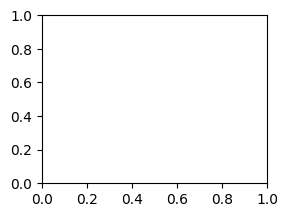

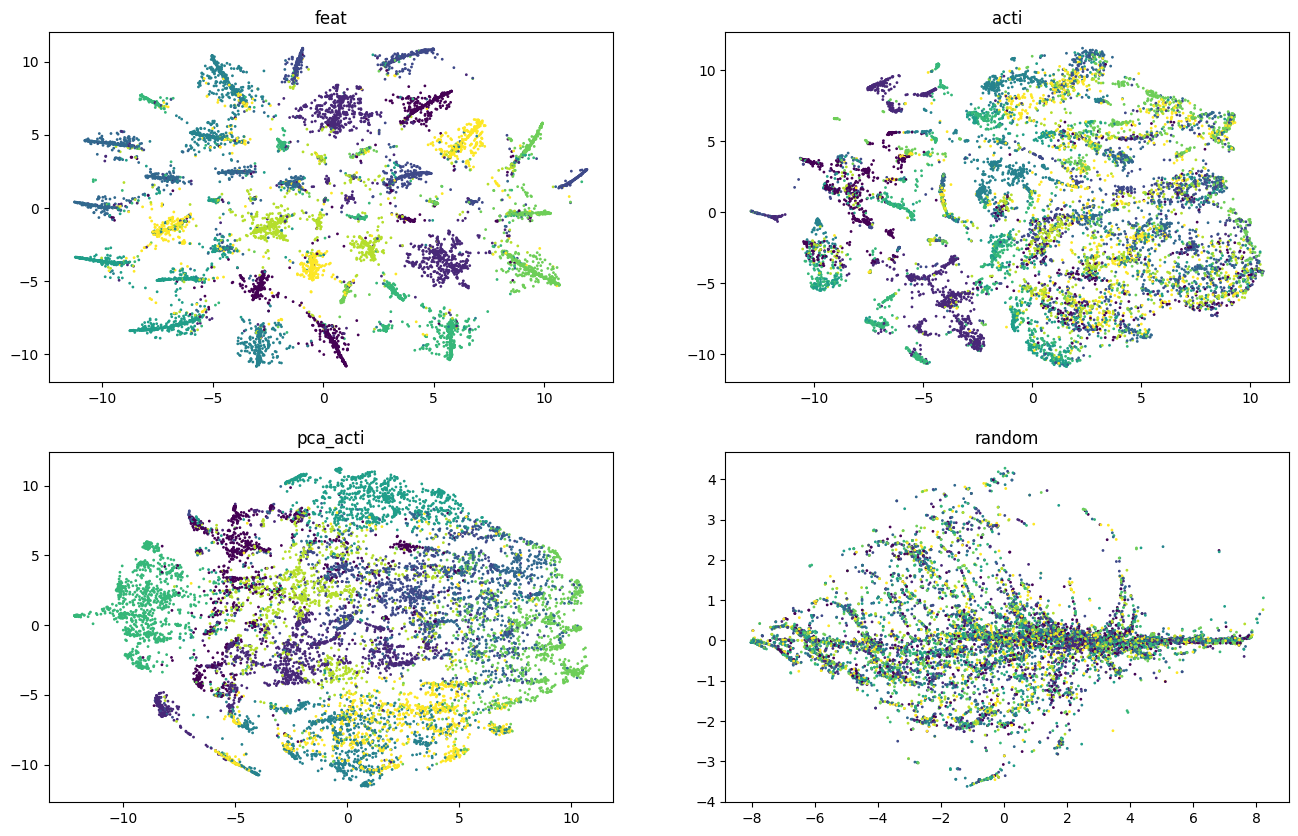

In [22]:
plt.subplot(2, 2, 1)
plt.figure(figsize=(16, 10))
for (id, elt, name) in zip(range(1, 5), comparison_list, names):
    plt.subplot(2, 2, id)
    elt = t.tensor(elt).float()
    elt = ablation_scrubb(elt, 1)
    tsne_show(elt)
    plt.title(name)
plt.savefig('mnist_tsne_ablation_scrubb.png')

# Features scatter

/tmp/ipykernel_3838344/2492656039.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elt = t.tensor(elt).float()


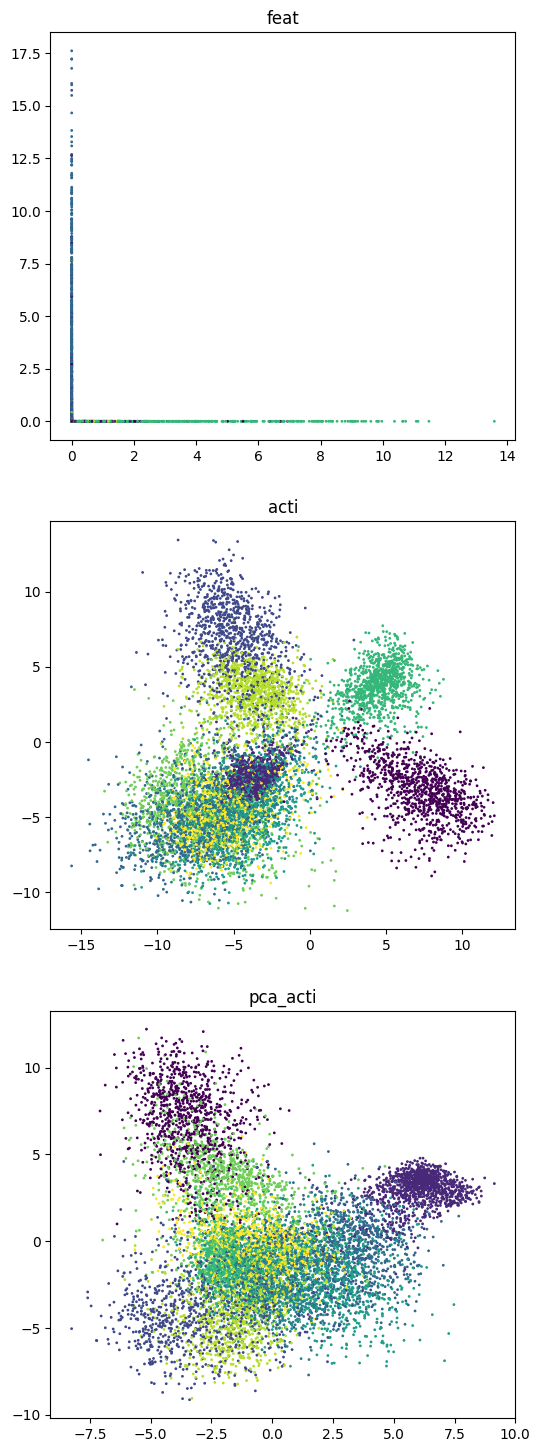

In [25]:

import matplotlib.pyplot as plt
def show(feat, i, j):
    X = feat[:, i]
    Y = feat[:, j]
    plt.scatter(X, Y, c = target[:samples], s = 1)
plt.figure(figsize=(6, 18))
# seed 0
random.seed(0)
for (id, elt, name) in zip(range(1, 4), comparison_list, names):
    plt.subplot(3, 1, id)
    elt = t.tensor(elt).float()
    i = random.randint(0, elt.shape[1] - 1)
    j = random.randint(0, elt.shape[1] - 1)
    if i == j:
        j = (j + 1) % elt.shape[1]
    show(elt, i, j)
    plt.title(name)
plt.savefig('show_scatter.png')

# Top samples visualization

/tmp/ipykernel_3838344/1247306810.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  elt = t.tensor(elt).float()


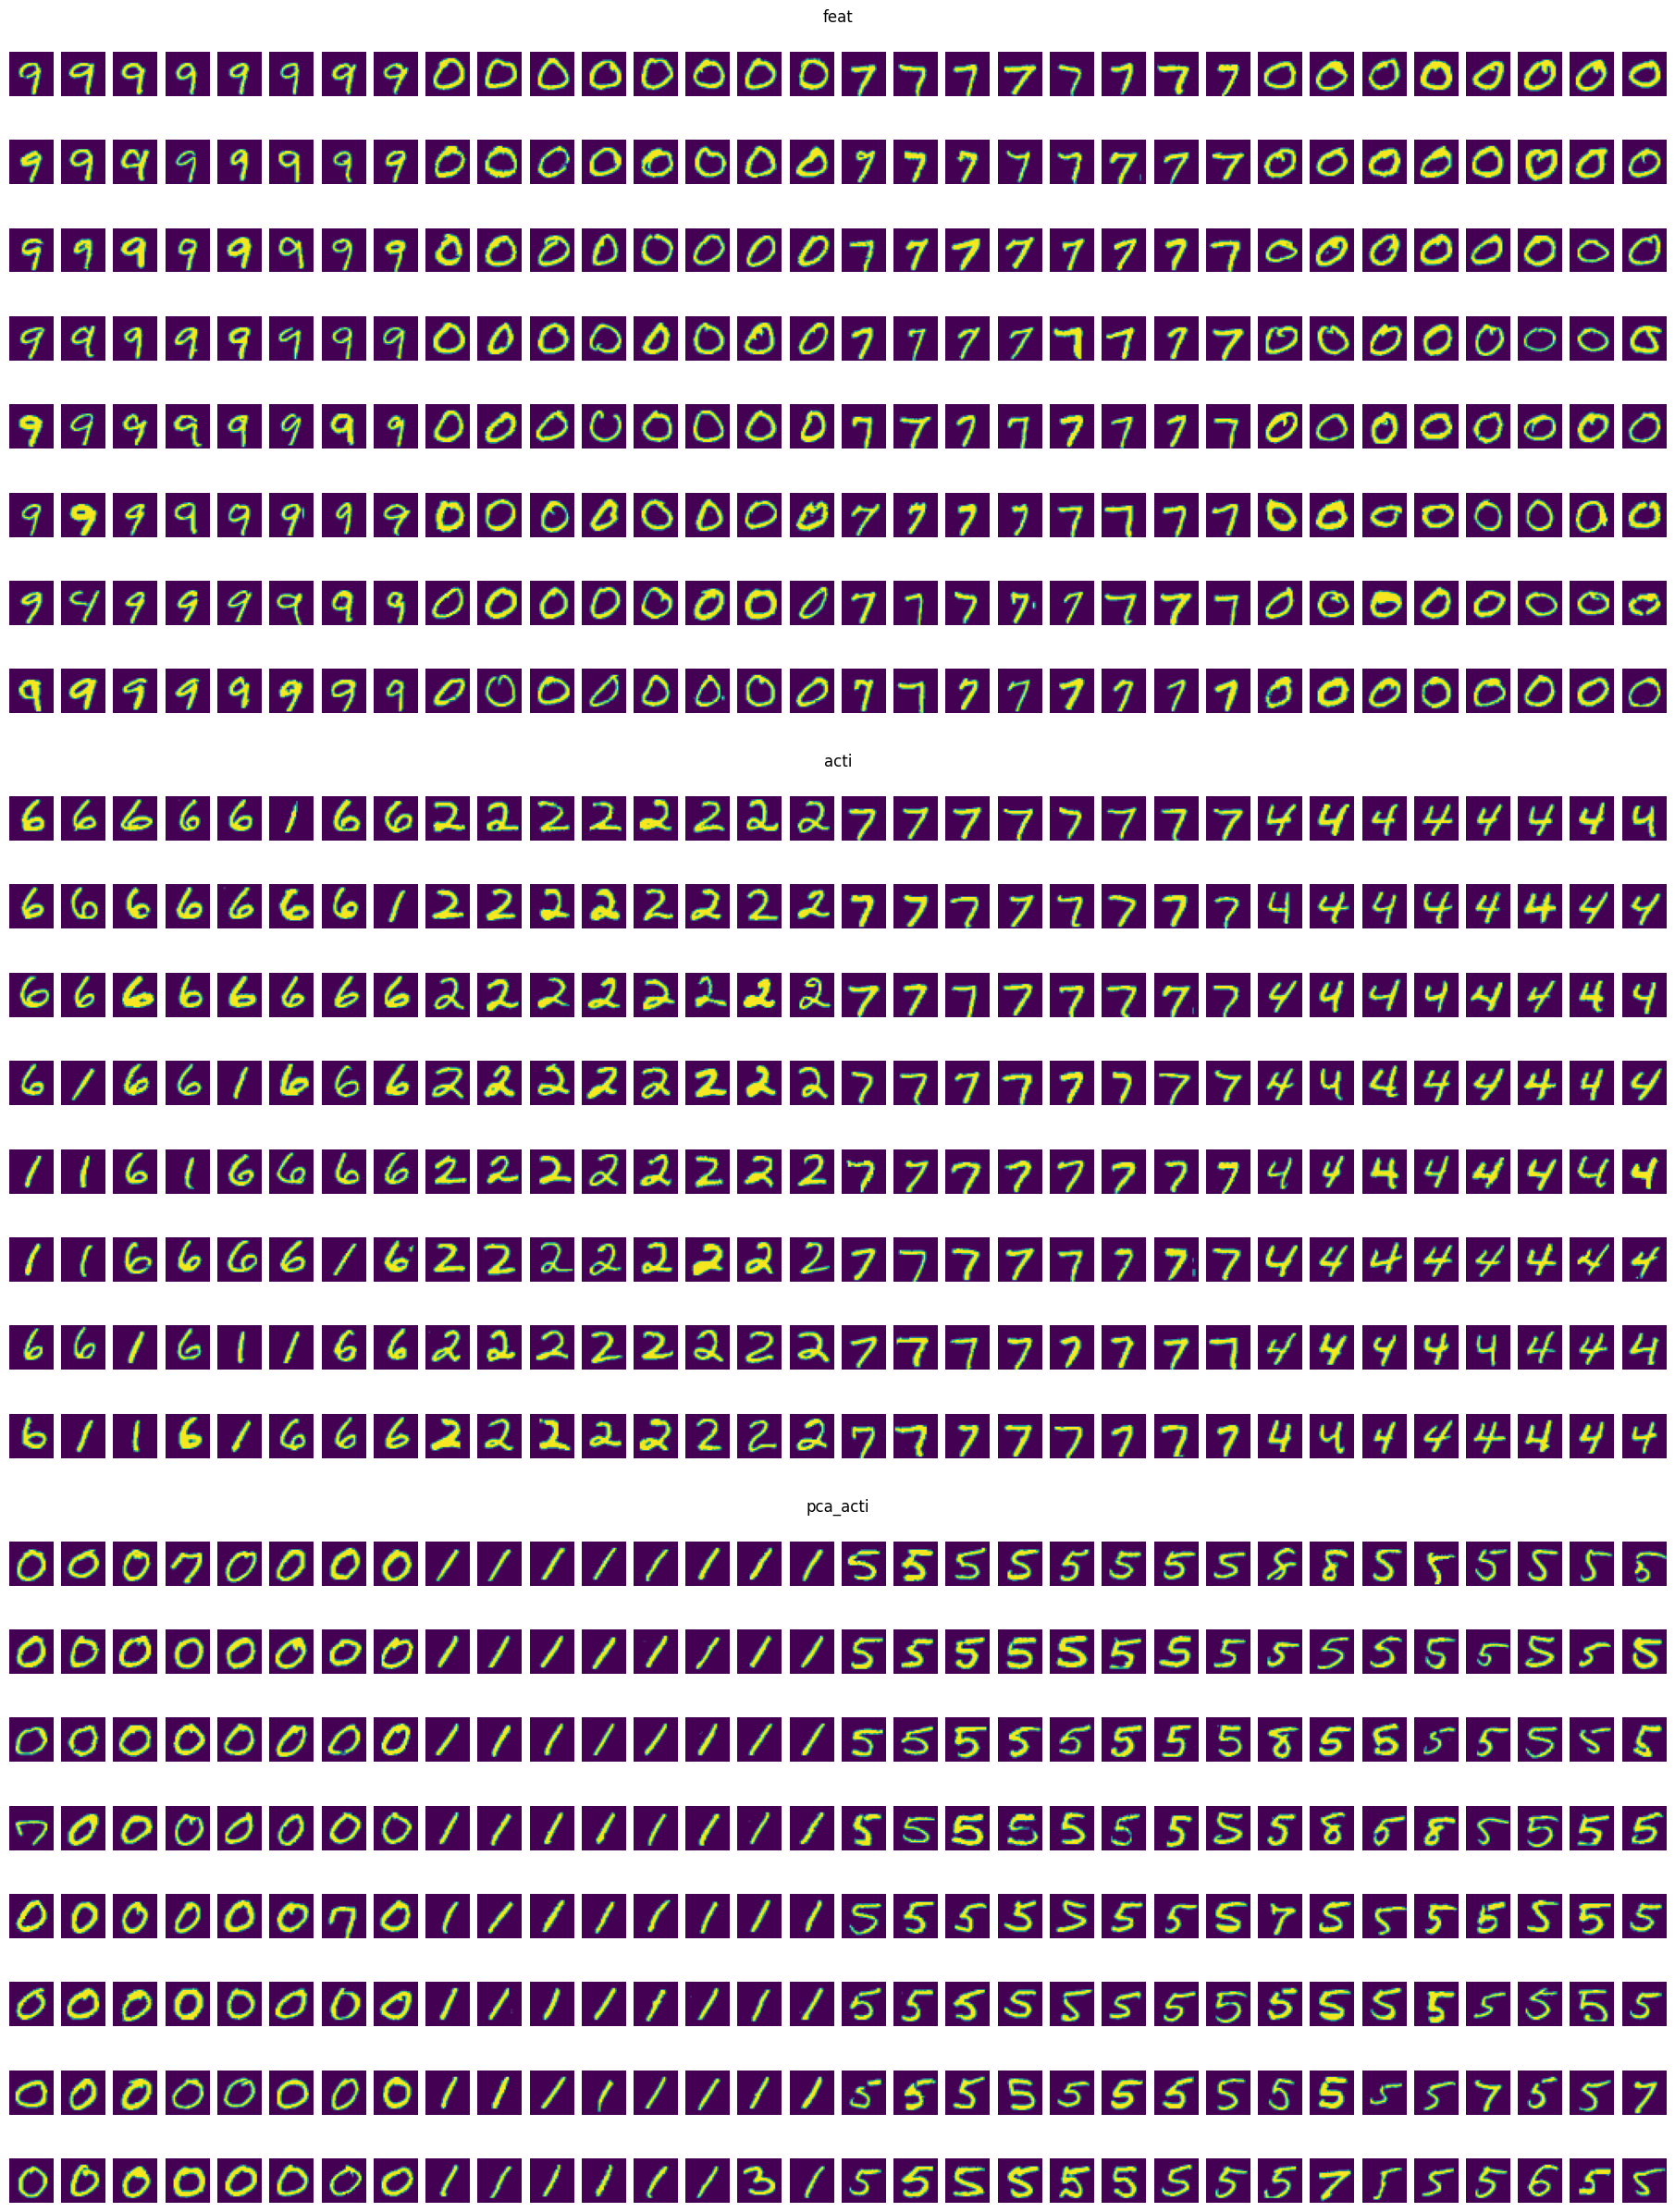

In [51]:

display_features = 4
fig = plt.figure(constrained_layout=True, figsize=(18, 6 * display_features))
subfigs = fig.subfigures(3, 1)
import matplotlib.pyplot as plt
for (id, elt, name, subfig) in zip(range(1, 4), comparison_list, names, subfigs):
    
    elt = t.tensor(elt).float()
    sample_size = 64
    feature_ids = random.sample(range(elt.shape[1]), display_features)
    axs = subfig.subplots(sample_size // 8, 8 * display_features)
    for i in range(display_features):
        feature_id = feature_ids[i]
        top_samples, acti = get_feat_top(data, elt, feature_id, sample_size)
        for j in range(len(top_samples)):
            ax = axs[j // 8, j % 8 + i * 8]
            ax.imshow(top_samples[j].reshape(28, 28))
            ax.axis('off')
    subfig.suptitle(name)
fig.savefig('mnist_show.png')
fig.show()
